# Exploring the relationship between aqueous solubility and Henry's law constants

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# for melting point predictions
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib widget

In [2]:
# loading dataset
df = pd.read_csv('curated_aqsoldb.csv')

In [3]:
# filtering compounds that have both solubility and hcp values
matched = df[df['Hcp'].notnull()]

In [4]:
# taking the log of hcp values to make scale more accessible
matched['log Hcp'] = [math.log(x, 10) for x in matched['Hcp']]

C:\Users\Alastair\AppData\Local\Temp/ipykernel_28308/3497579970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched['log Hcp'] = [math.log(x, 10) for x in matched['Hcp']]


### First plotting log S, log Hcp, and melting point against each other to see relationships

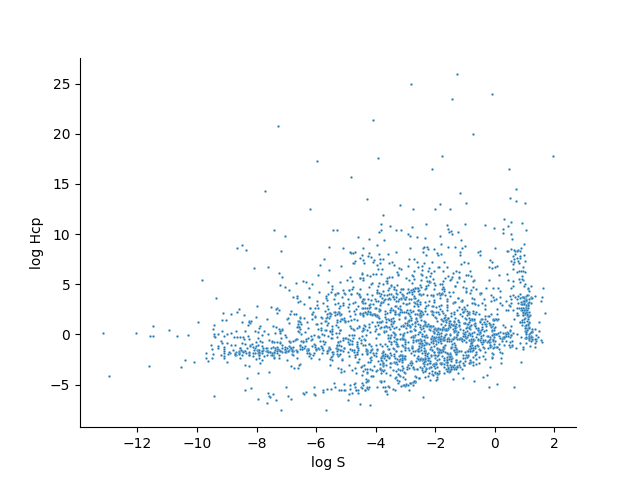

In [5]:
sns.scatterplot(data=matched, x='Solubility', y='log Hcp', s=3).set(xlabel='log S')
sns.despine()
plt.savefig('logs_loghcp.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# filtering out compounds which don't have a mp value
mp_match = matched[matched['Melting Point'].notnull()]

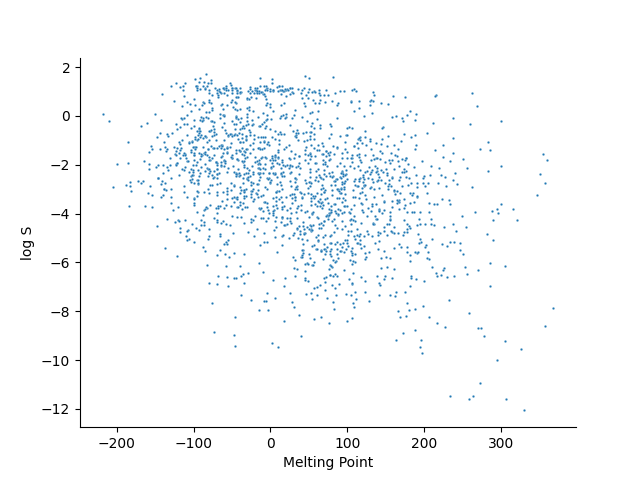

In [7]:
plt.close()
sns.scatterplot(data=mp_match, x='Melting Point', y='Solubility', s=3).set(ylabel='log S')
sns.despine()
plt.savefig('logs_mp.jpg', dpi=300, bbox_inches='tight')
plt.show()

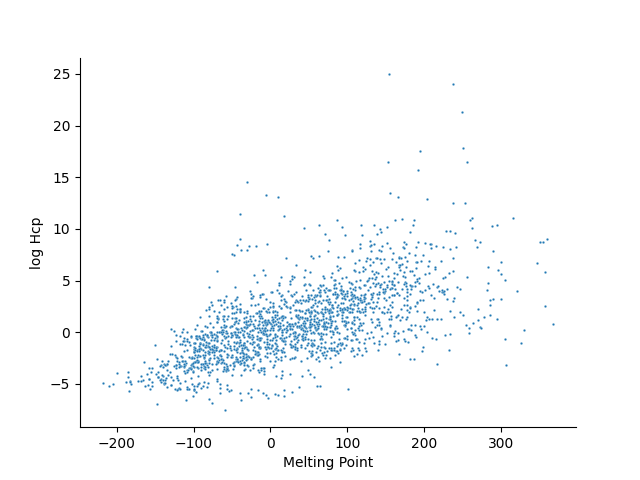

In [8]:
plt.close()
sns.scatterplot(data=mp_match, x='Melting Point', y='log Hcp', s=3)
sns.despine()
plt.savefig('loghcp_mp.jpg', dpi=300, bbox_inches='tight')
plt.show()

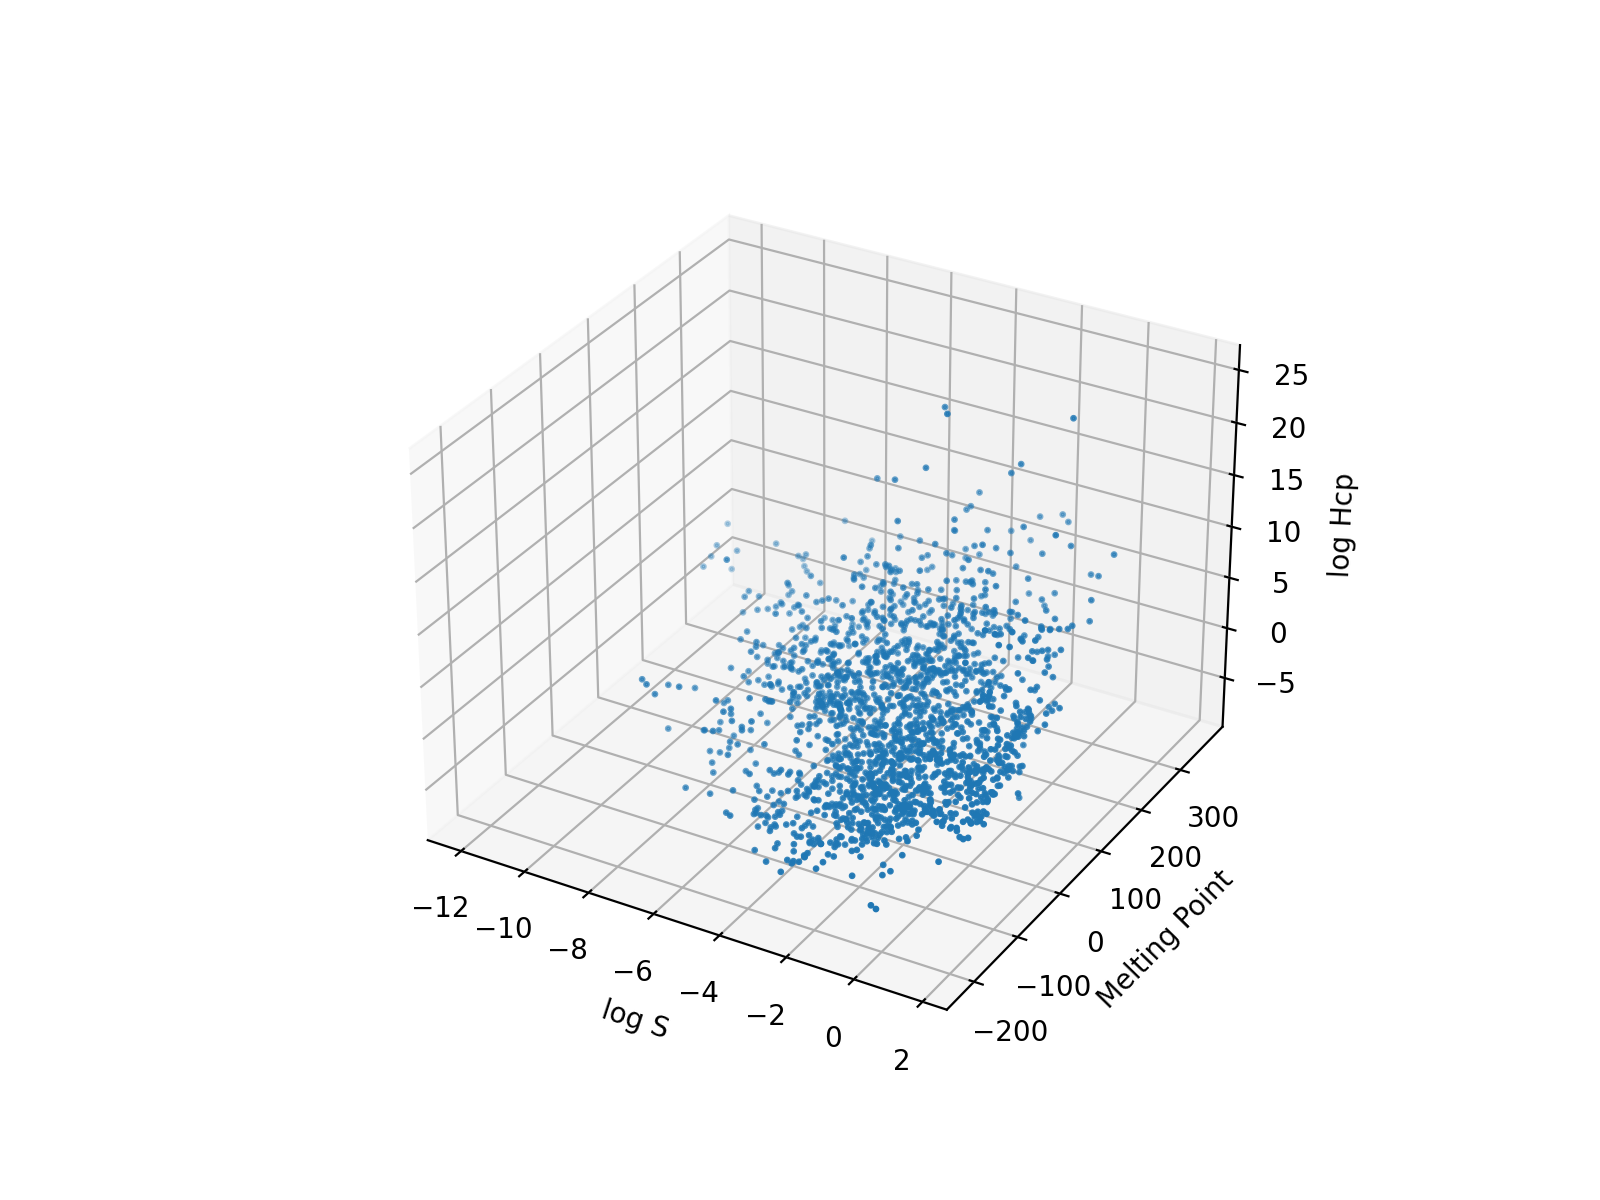

In [9]:
# 3D scatter plot of solubility, hcp and mp values
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(projection='3d')

ax.scatter(mp_match['Solubility'], mp_match['Melting Point'], mp_match['log Hcp'], s=2)

ax.set_xlabel('log S')
ax.set_ylabel('Melting Point')
ax.set_zlabel('log Hcp')

plt.savefig('s_hcp_mp_scatter.jpg', bbox_inches='tight', dpi=300)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


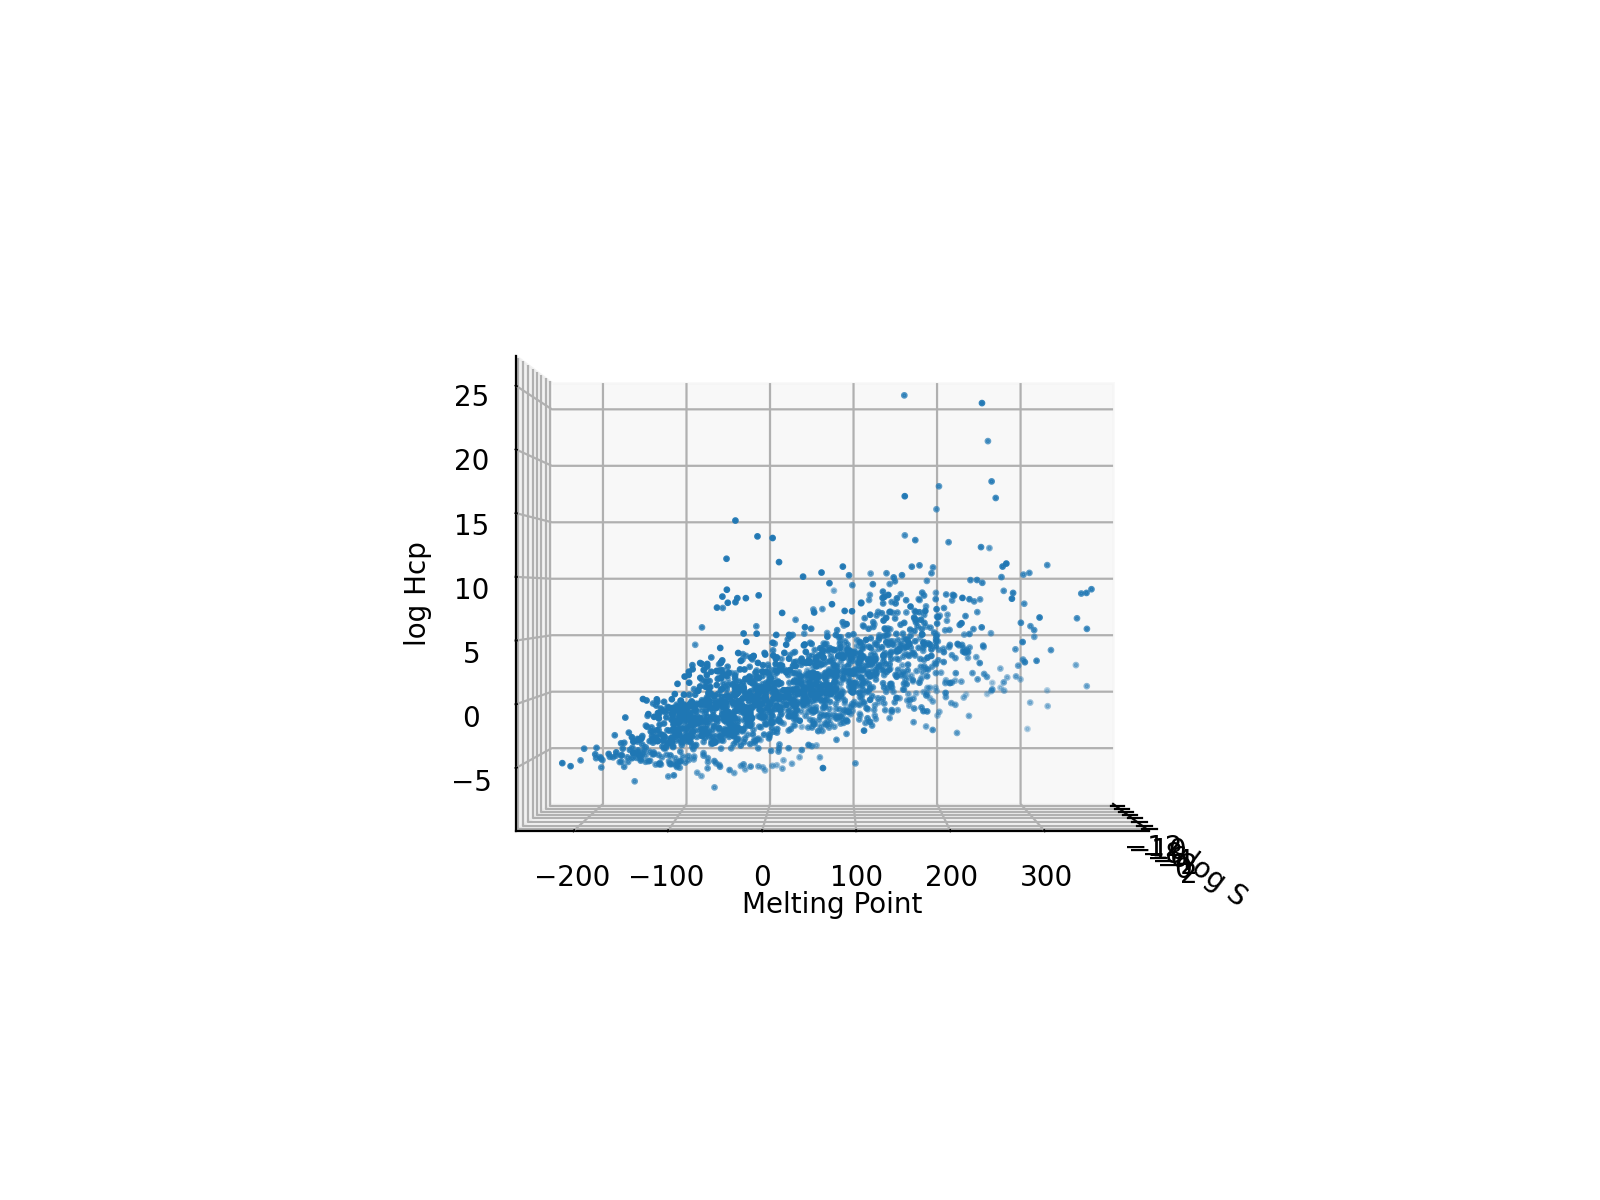

In [10]:
# 3D scatter plot of solubility, hcp and mp values
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(projection='3d')

ax.scatter(mp_match['Solubility'], mp_match['Melting Point'], mp_match['log Hcp'], s=2)

ax.set_xlabel('log S')
ax.set_ylabel('Melting Point')
ax.set_zlabel('log Hcp')

def rotate(angle):
    ax.view_init(azim=angle, elev=0)

# making an animation to save as gif
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
rot_animation.save('rotation.gif', dpi=300)

plt.show()

## Plotting plane of best fit

In [11]:
from skspatial.objects import Plane
from skspatial.objects import Points
from skspatial.plotting import plot_3d

from sklearn.preprocessing import PowerTransformer

In [12]:
# scaling melting points so is more comparable to log s and log hcp
pt = PowerTransformer(method='yeo-johnson', standardize=True)
mp_match['mpTransformed'] = pt.fit_transform(mp_match['Melting Point'].values.reshape(-1,1))

C:\Users\Alastair\AppData\Local\Temp/ipykernel_28308/4019934556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp_match['mpTransformed'] = pt.fit_transform(mp_match['Melting Point'].values.reshape(-1,1))


In [13]:
points = mp_match[['Solubility', 'mpTransformed', 'log Hcp']]

In [14]:
# converting relevant dataframe columns in numpy arrays which can be used as coordinates
points = points.to_numpy()

In [15]:
points

array([[-3.1231503 , -1.21488201, -2.50863831],
       [-2.46603079,  0.61403469,  3.95424251],
       [-3.41151388, -0.85332397, -3.537602  ],
       ...,
       [-2.73      ,  1.47772014,  7.50514998],
       [-2.19      ,  0.24724936,  0.47712125],
       [-4.78      ,  1.16901645,  4.56820172]])

In [16]:
# converting coordinates into skspatial Points object
points = Points(points)

In [17]:
# finding plane of best fit =
plane = Plane.best_fit(points)

MovieWriter ffmpeg unavailable; using Pillow instead.


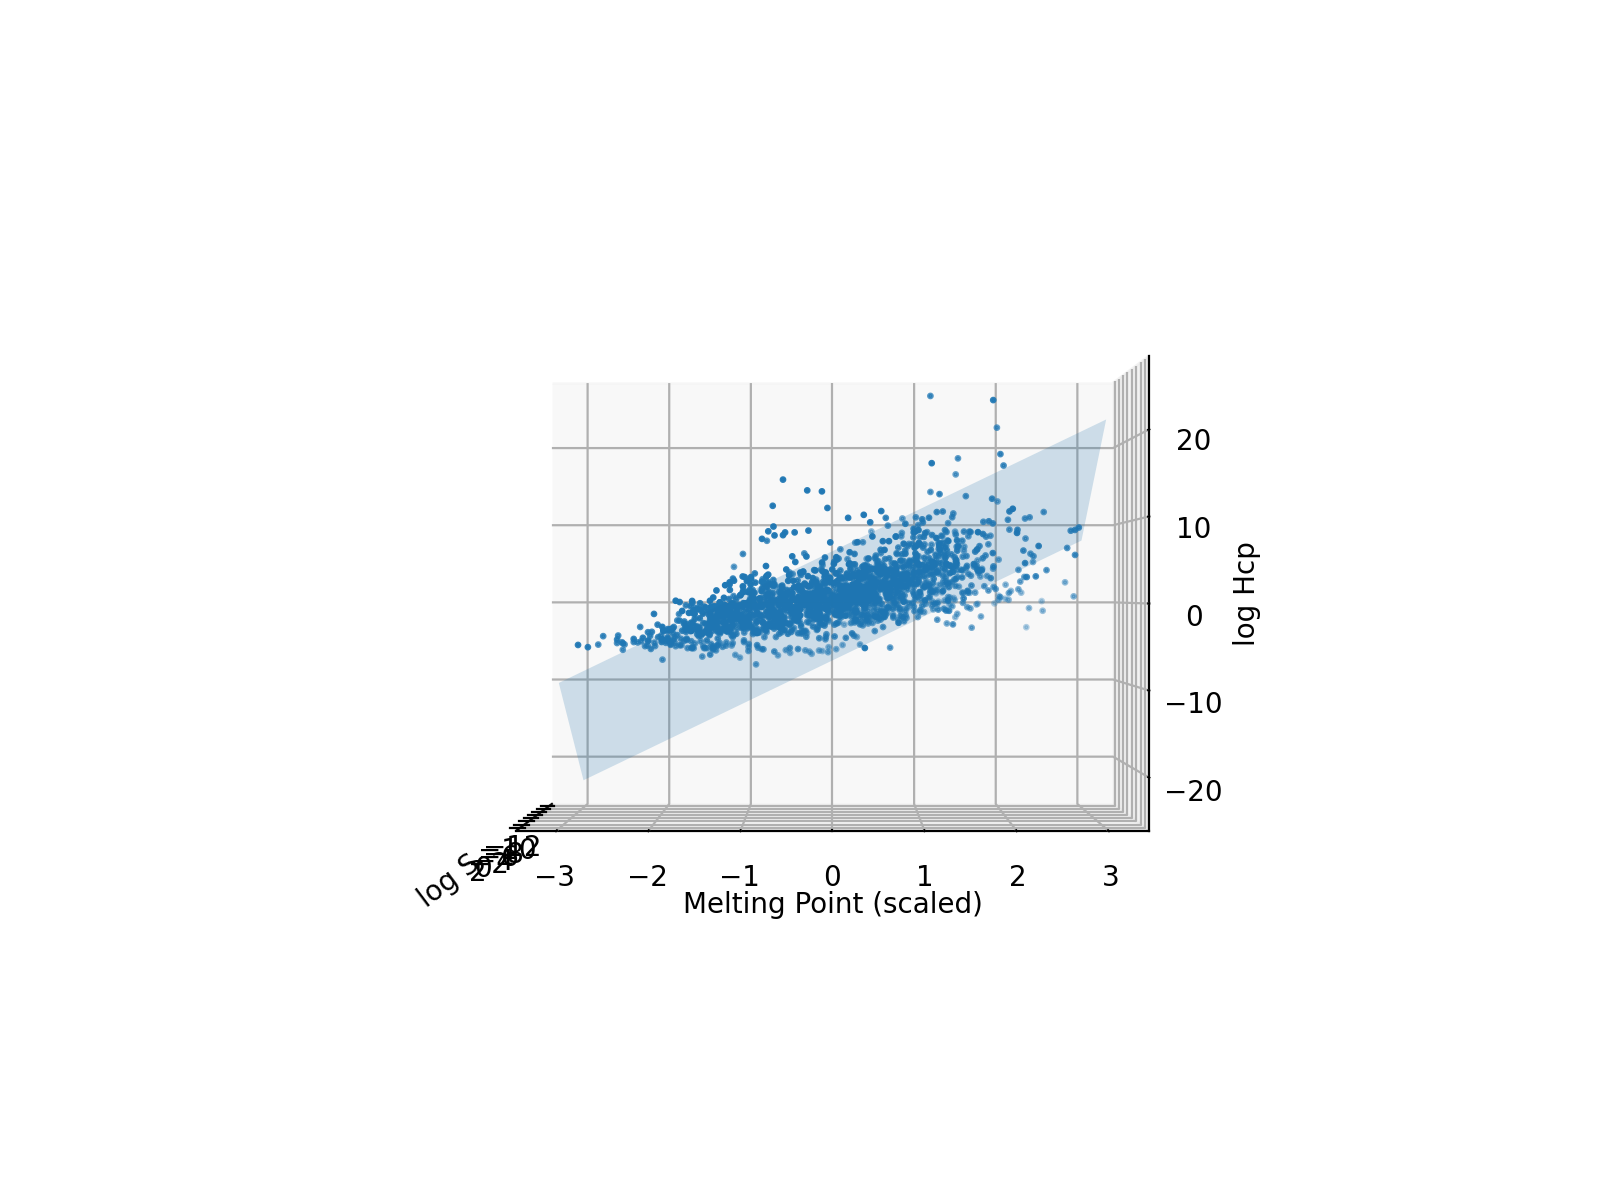

In [18]:
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(projection='3d')

# plotting plane of best fit along with scatter points
points.plot_3d(ax, s=2)
plane.plot_3d(ax, lims_x=(-8, 5), lims_y=(-3, 3), alpha=0.2)

ax.set_xlabel('log S')
ax.set_ylabel('Melting Point (scaled)')
ax.set_zlabel('log Hcp')

# create function that rotates graph
def rotate(angle):
    ax.view_init(azim=angle, elev=0)

# making an animation of rotating graph to save as gif
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
rot_animation.save('rotation_with_plane.gif', dpi=300)

plt.show()

In [19]:
# cartesian coordiates of plane
plane.cartesian()

(-0.19526469583217496,
 -0.9623754218329871,
 0.18895831819040915,
 -0.6933842186410031)

### removing outliers to get better plane of best fit

taking outliers to be:
- Q1 - 1.5 * IQR
- Q3 + 1.5 * IQR

#### solubility outliers

In [20]:
# first finding log s outlier boundaries
q3, q1 = np.percentile(mp_match['Solubility'], [75, 25])

lower_outliers = q1 - 1.5 * (q3 - q1)
upper_outliers = q3 + 1.5 * (q3 - q1)

In [21]:
# removing outliers
mp_match = mp_match[mp_match['Solubility'] > lower_outliers]
mp_match = mp_match[mp_match['Solubility'] < upper_outliers]

In [22]:
mp_match

,level_0,index,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,...,TPSA,LabuteASA,BalabanJ,BertzCT,Species,Hcp,CID,Melting Point,log Hcp,mpTransformed
5,5,5,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,...,0.00,55.836626,3.070761,211.033225,1-ethenyl-3-methylbenzene,3.100000e-03,7529.0,-86.30,-2.508638,-1.214882
16,16,16,A-24,2-(4-chloro-2-methylphenoxy)propanoic acid,InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2...,WNTGYJSOUMFZEP-UHFFFAOYSA-N,CC(Oc1ccc(Cl)cc1C)C(O)=O,-2.466031,0.060621,4,...,46.53,87.263739,2.817665,349.220389,mecoprop,9.000000e+03,7153.0,94.50,3.954243,0.614035
18,18,18,A-26,1-chloro-3-(trifluoromethyl)benzene,"InChI=1S/C7H4ClF3/c8-6-3-1-2-5(4-6)7(9,10)11/h...",YTCGOUNVIAWCMG-UHFFFAOYSA-N,FC(F)(F)c1cccc(Cl)c1,-3.411514,0.000000,1,...,0.00,66.596218,3.059902,254.107753,1-chloro-3-(trifluoromethyl)benzene,2.900000e-04,7374.0,-56.00,-3.537602,-0.853324
27,27,27,A-36,"(1S,5S)-6,6-dimethyl-2-methylidenebicyclo[3.1....","InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h8-9...",WTARULDDTDQWMU-UHFFFAOYSA-N,CC1(C)C2CCC(=C)C1C2,-4.292313,1.247787,3,...,0.00,63.322465,2.231081,174.477332,$\beta$-pinene,1.600000e-04,14896.0,-61.25,-3.795880,-0.915520
30,30,30,A-45,hydroxylamine,"InChI=1S/H3NO/c1-2/h2H,1H2",AVXURJPOCDRRFD-UHFFFAOYSA-N,NO,-0.763034,0.861298,7,...,46.25,12.462472,1.000000,2.000000,hydroxylamine,1.400000e+03,787.0,33.00,3.146128,0.086132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,10046,9965,I-63,papaverine,InChI=1S/C20H21NO4/c1-22-17-6-5-13(10-18(17)23...,XQYZDYMELSJDRZ-UHFFFAOYSA-N,c1(nccc2cc(c(OC)cc12)OC)Cc1cc(c(cc1)OC)OC,-3.870000,0.790000,2,...,49.81,146.668701,2.039871,892.243703,papaverine,1.300000e+07,4680.0,147.50,7.113943,1.057225
9967,10048,9967,I-66,phenobarbital,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,DDBREPKUVSBGFI-UHFFFAOYSA-N,C1(NC(C(c2ccccc2)(C(=O)N1)CC)=O)=O,-2.290000,0.095670,5,...,75.27,98.199515,2.535973,461.783925,phenobarbital,5.800000e+08,4763.0,174.00,8.763428,1.276322
9974,10055,9974,I-79,sulfamethazine,InChI=1S/C12H14N4O2S/c1-8-7-9(2)15-12(14-8)16-...,ASWVTGNCAZCNNR-UHFFFAOYSA-N,S(=O)(=O)(Nc1nc(C)cc(n1)C)c1ccc(N)cc1,-2.730000,0.230750,2,...,97.97,111.308206,2.330509,675.919365,sulfamethazine,3.200000e+07,5327.0,198.50,7.505150,1.477720
9979,10060,9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,...,20.23,67.685405,3.092720,251.049732,5-methyl-2-(1-methylethyl)-phenol,3.000000e+00,6989.0,51.50,0.477121,0.247249


#### HLC outliers

In [23]:
# finding hlc outlier boundaries
q3, q1 = np.percentile(mp_match['log Hcp'], [75, 25])

lower_outliers = q1 - 1.5 * (q3 - q1)
upper_outliers = q3 + 1.5 * (q3 - q1)

In [24]:
# removing outliers
mp_match = mp_match[mp_match['log Hcp'] > lower_outliers]
mp_match = mp_match[mp_match['log Hcp'] < upper_outliers]

In [25]:
mp_match

,level_0,index,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,...,TPSA,LabuteASA,BalabanJ,BertzCT,Species,Hcp,CID,Melting Point,log Hcp,mpTransformed
5,5,5,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,...,0.00,55.836626,3.070761,211.033225,1-ethenyl-3-methylbenzene,3.100000e-03,7529.0,-86.30,-2.508638,-1.214882
16,16,16,A-24,2-(4-chloro-2-methylphenoxy)propanoic acid,InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2...,WNTGYJSOUMFZEP-UHFFFAOYSA-N,CC(Oc1ccc(Cl)cc1C)C(O)=O,-2.466031,0.060621,4,...,46.53,87.263739,2.817665,349.220389,mecoprop,9.000000e+03,7153.0,94.50,3.954243,0.614035
18,18,18,A-26,1-chloro-3-(trifluoromethyl)benzene,"InChI=1S/C7H4ClF3/c8-6-3-1-2-5(4-6)7(9,10)11/h...",YTCGOUNVIAWCMG-UHFFFAOYSA-N,FC(F)(F)c1cccc(Cl)c1,-3.411514,0.000000,1,...,0.00,66.596218,3.059902,254.107753,1-chloro-3-(trifluoromethyl)benzene,2.900000e-04,7374.0,-56.00,-3.537602,-0.853324
27,27,27,A-36,"(1S,5S)-6,6-dimethyl-2-methylidenebicyclo[3.1....","InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h8-9...",WTARULDDTDQWMU-UHFFFAOYSA-N,CC1(C)C2CCC(=C)C1C2,-4.292313,1.247787,3,...,0.00,63.322465,2.231081,174.477332,$\beta$-pinene,1.600000e-04,14896.0,-61.25,-3.795880,-0.915520
30,30,30,A-45,hydroxylamine,"InChI=1S/H3NO/c1-2/h2H,1H2",AVXURJPOCDRRFD-UHFFFAOYSA-N,NO,-0.763034,0.861298,7,...,46.25,12.462472,1.000000,2.000000,hydroxylamine,1.400000e+03,787.0,33.00,3.146128,0.086132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,10046,9965,I-63,papaverine,InChI=1S/C20H21NO4/c1-22-17-6-5-13(10-18(17)23...,XQYZDYMELSJDRZ-UHFFFAOYSA-N,c1(nccc2cc(c(OC)cc12)OC)Cc1cc(c(cc1)OC)OC,-3.870000,0.790000,2,...,49.81,146.668701,2.039871,892.243703,papaverine,1.300000e+07,4680.0,147.50,7.113943,1.057225
9967,10048,9967,I-66,phenobarbital,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,DDBREPKUVSBGFI-UHFFFAOYSA-N,C1(NC(C(c2ccccc2)(C(=O)N1)CC)=O)=O,-2.290000,0.095670,5,...,75.27,98.199515,2.535973,461.783925,phenobarbital,5.800000e+08,4763.0,174.00,8.763428,1.276322
9974,10055,9974,I-79,sulfamethazine,InChI=1S/C12H14N4O2S/c1-8-7-9(2)15-12(14-8)16-...,ASWVTGNCAZCNNR-UHFFFAOYSA-N,S(=O)(=O)(Nc1nc(C)cc(n1)C)c1ccc(N)cc1,-2.730000,0.230750,2,...,97.97,111.308206,2.330509,675.919365,sulfamethazine,3.200000e+07,5327.0,198.50,7.505150,1.477720
9979,10060,9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,...,20.23,67.685405,3.092720,251.049732,5-methyl-2-(1-methylethyl)-phenol,3.000000e+00,6989.0,51.50,0.477121,0.247249


#### melting point outliers

In [26]:
# finding mp outlier boundaries
q3, q1 = np.percentile(mp_match['mpTransformed'], [75, 25])

lower_outliers = q1 - 1.5 * (q3 - q1)
upper_outliers = q3 + 1.5 * (q3 - q1)

In [27]:
# removing outliers
mp_match = mp_match[mp_match['mpTransformed'] > lower_outliers]
mp_match = mp_match[mp_match['mpTransformed'] < upper_outliers]

In [28]:
mp_match

,level_0,index,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,...,TPSA,LabuteASA,BalabanJ,BertzCT,Species,Hcp,CID,Melting Point,log Hcp,mpTransformed
5,5,5,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,...,0.00,55.836626,3.070761,211.033225,1-ethenyl-3-methylbenzene,3.100000e-03,7529.0,-86.30,-2.508638,-1.214882
16,16,16,A-24,2-(4-chloro-2-methylphenoxy)propanoic acid,InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2...,WNTGYJSOUMFZEP-UHFFFAOYSA-N,CC(Oc1ccc(Cl)cc1C)C(O)=O,-2.466031,0.060621,4,...,46.53,87.263739,2.817665,349.220389,mecoprop,9.000000e+03,7153.0,94.50,3.954243,0.614035
18,18,18,A-26,1-chloro-3-(trifluoromethyl)benzene,"InChI=1S/C7H4ClF3/c8-6-3-1-2-5(4-6)7(9,10)11/h...",YTCGOUNVIAWCMG-UHFFFAOYSA-N,FC(F)(F)c1cccc(Cl)c1,-3.411514,0.000000,1,...,0.00,66.596218,3.059902,254.107753,1-chloro-3-(trifluoromethyl)benzene,2.900000e-04,7374.0,-56.00,-3.537602,-0.853324
27,27,27,A-36,"(1S,5S)-6,6-dimethyl-2-methylidenebicyclo[3.1....","InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h8-9...",WTARULDDTDQWMU-UHFFFAOYSA-N,CC1(C)C2CCC(=C)C1C2,-4.292313,1.247787,3,...,0.00,63.322465,2.231081,174.477332,$\beta$-pinene,1.600000e-04,14896.0,-61.25,-3.795880,-0.915520
30,30,30,A-45,hydroxylamine,"InChI=1S/H3NO/c1-2/h2H,1H2",AVXURJPOCDRRFD-UHFFFAOYSA-N,NO,-0.763034,0.861298,7,...,46.25,12.462472,1.000000,2.000000,hydroxylamine,1.400000e+03,787.0,33.00,3.146128,0.086132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,10046,9965,I-63,papaverine,InChI=1S/C20H21NO4/c1-22-17-6-5-13(10-18(17)23...,XQYZDYMELSJDRZ-UHFFFAOYSA-N,c1(nccc2cc(c(OC)cc12)OC)Cc1cc(c(cc1)OC)OC,-3.870000,0.790000,2,...,49.81,146.668701,2.039871,892.243703,papaverine,1.300000e+07,4680.0,147.50,7.113943,1.057225
9967,10048,9967,I-66,phenobarbital,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,DDBREPKUVSBGFI-UHFFFAOYSA-N,C1(NC(C(c2ccccc2)(C(=O)N1)CC)=O)=O,-2.290000,0.095670,5,...,75.27,98.199515,2.535973,461.783925,phenobarbital,5.800000e+08,4763.0,174.00,8.763428,1.276322
9974,10055,9974,I-79,sulfamethazine,InChI=1S/C12H14N4O2S/c1-8-7-9(2)15-12(14-8)16-...,ASWVTGNCAZCNNR-UHFFFAOYSA-N,S(=O)(=O)(Nc1nc(C)cc(n1)C)c1ccc(N)cc1,-2.730000,0.230750,2,...,97.97,111.308206,2.330509,675.919365,sulfamethazine,3.200000e+07,5327.0,198.50,7.505150,1.477720
9979,10060,9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,...,20.23,67.685405,3.092720,251.049732,5-methyl-2-(1-methylethyl)-phenol,3.000000e+00,6989.0,51.50,0.477121,0.247249


### now finding new plane of best fit

In [29]:
points = mp_match[['Solubility', 'mpTransformed', 'log Hcp']]

In [30]:
# converting relevant dataframe columns in numpy arrays which can be used as coordinates
points = points.to_numpy()

In [31]:
points

array([[-3.1231503 , -1.21488201, -2.50863831],
       [-2.46603079,  0.61403469,  3.95424251],
       [-3.41151388, -0.85332397, -3.537602  ],
       ...,
       [-2.73      ,  1.47772014,  7.50514998],
       [-2.19      ,  0.24724936,  0.47712125],
       [-4.78      ,  1.16901645,  4.56820172]])

In [32]:
# converting coordinates into skspatial Points object
points = Points(points)

In [33]:
# finding plane of best fit =
plane = Plane.best_fit(points)

MovieWriter ffmpeg unavailable; using Pillow instead.


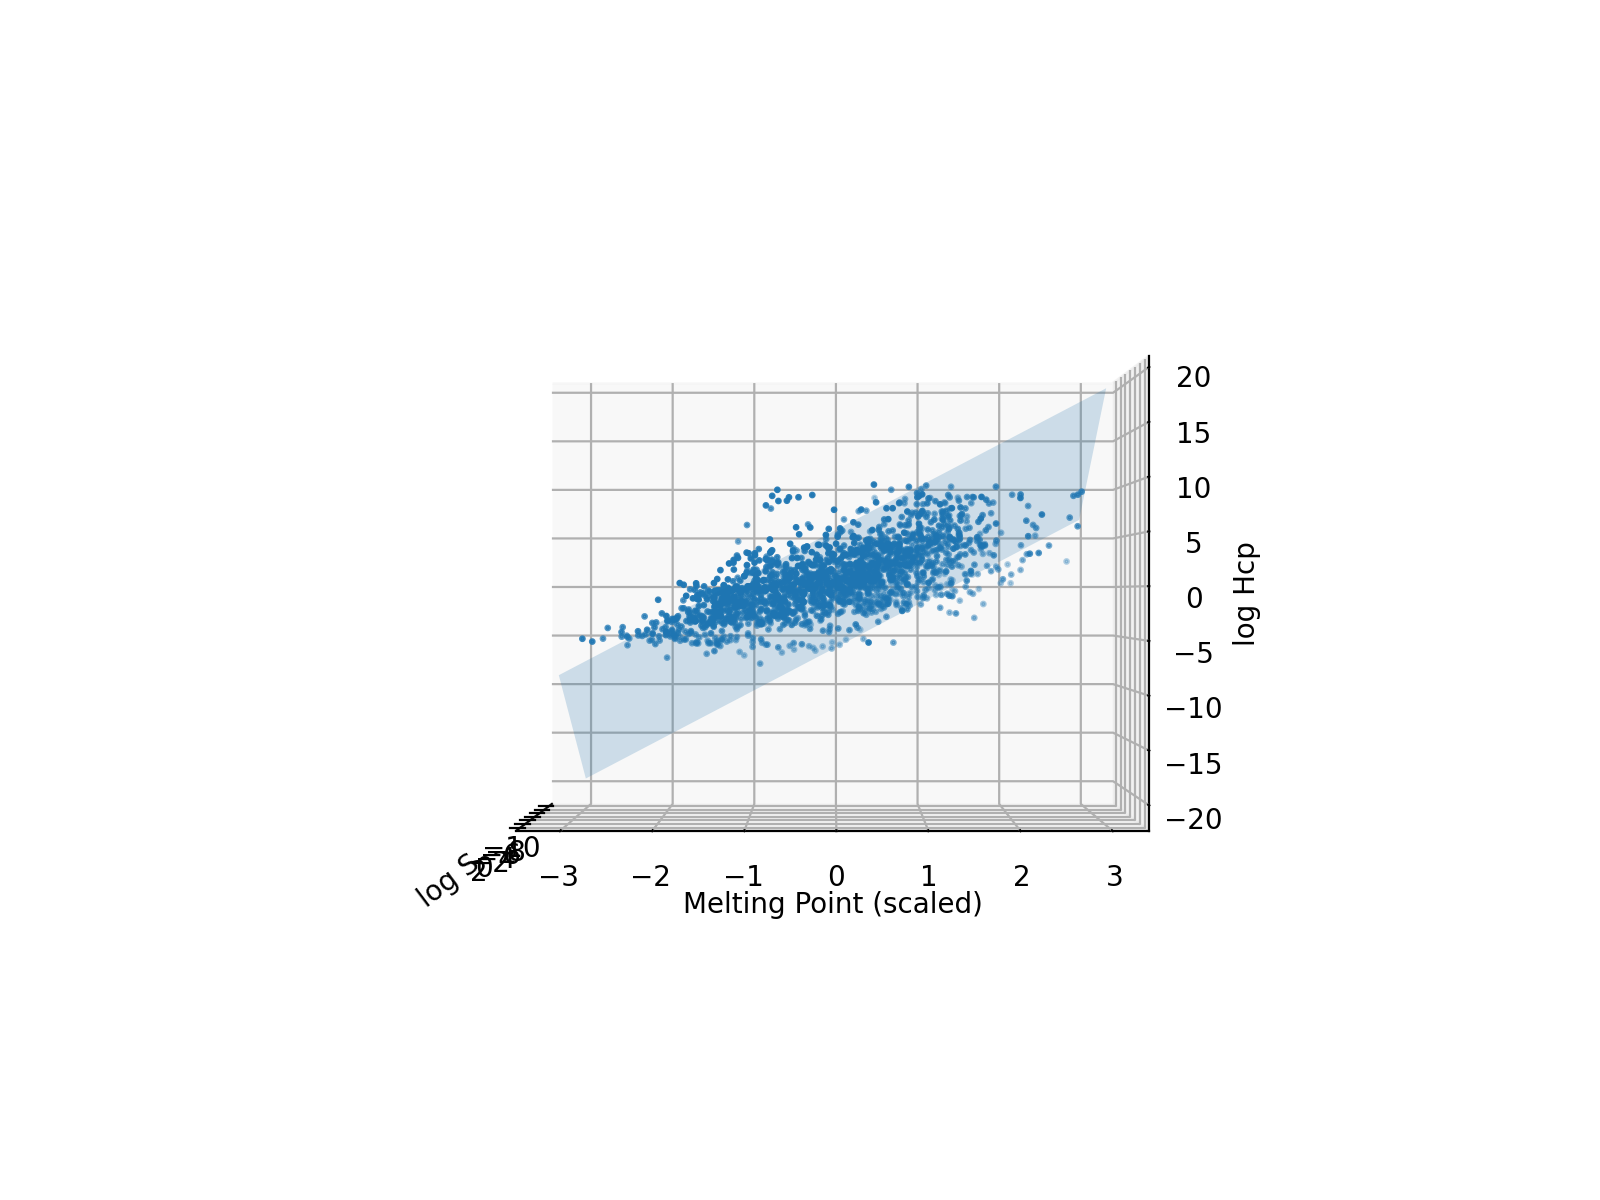

In [34]:
plt.close()

fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(projection='3d')

# plotting plane of best fit along with scatter points
points.plot_3d(ax, s=2)
plane.plot_3d(ax, lims_x=(-8, 5), lims_y=(-3, 3), alpha=0.2)

ax.set_xlabel('log S')
ax.set_ylabel('Melting Point (scaled)')
ax.set_zlabel('log Hcp')

# create function that rotates graph
def rotate(angle):
    ax.view_init(azim=angle, elev=0)

# making an animation of rotating graph to save as gif
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
rot_animation.save('rotation_with_plane_no_outliers.gif', dpi=300)

plt.show()

In [35]:
# cartesian coordiates of plane
plane.cartesian()

(-0.19028294066267004,
 -0.9573843648705846,
 0.21727305491964247,
 -0.6799188586434917)

## Melting point predictions using experimental data

using the equation -0.7891949689500798 * log S - 0.01926324742776453 * MP + 0.6138405560749627 * log Hcp - 1.9103492564962359 = 0

rearranging to find the MP gives the following equation -> MP = 1/0.01926324742776453 * (-0.7891949689500798 * log S + 0.6138405560749627 * log Hcp - 1.9103492564962359)

In [36]:
mp_match['MeltingPointExpPredicted'] = mp_match.apply(lambda x: 1/0.9573843648705846 * (-0.19028294066267004 * x['Solubility'] + 0.21727305491964247 * x['log Hcp'] - 0.6799188586434917), axis=1)                                             

In [37]:
mp_match['MeltingPointExpPredicted'] = pt.inverse_transform(mp_match['MeltingPointExpPredicted'].values.reshape(-1, 1))

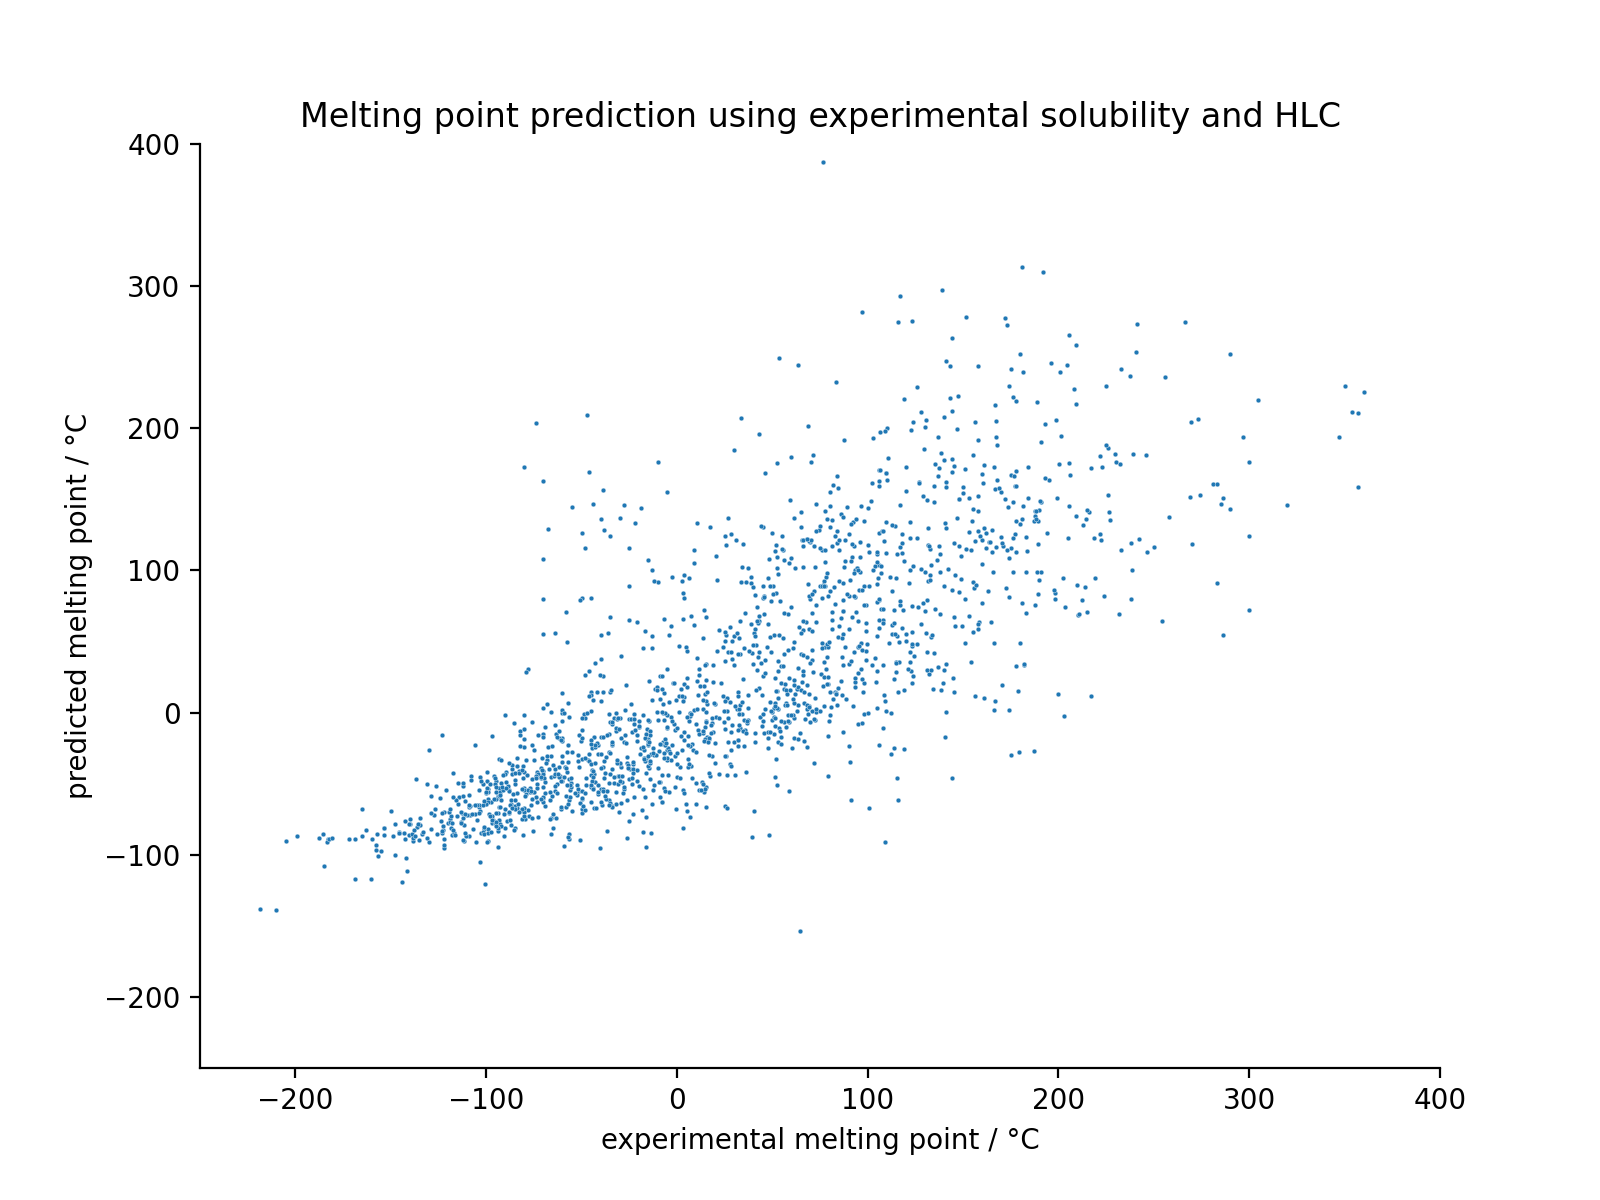

In [38]:
plt.clf()
sns.scatterplot(data=mp_match, x='Melting Point', y='MeltingPointExpPredicted', s=3).set(title='Melting point prediction using experimental solubility and HLC', xlabel='experimental melting point / °C', ylabel='predicted melting point / °C')

# set axis limits to be the same
plt.xlim(-250, 400)
plt.ylim(-250, 400)

sns.despine()
plt.savefig('mp_prediction.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
print(mean_squared_error(mp_match['Melting Point'], mp_match['MeltingPointExpPredicted'], squared=False))

63.94025666059953


In [40]:
r2_score(mp_match['Melting Point'], mp_match['MeltingPointExpPredicted'])

0.5986618859549364

## Melting point predictions using random forest predicted data

using the equation -0.7891949689500798 * log S - 0.01926324742776453 * MP + 0.6138405560749627 * log Hcp - 1.9103492564962359 = 0

rearranging to find the MP gives the following equation -> MP = 1/0.01926324742776453 * (-0.7891949689500798 * log S + 0.6138405560749627 * log Hcp - 1.9103492564962359)

In [41]:
# importing rfr solubility predictions
sol_predictions = pd.read_csv('best_sol_predictions.csv')

# inserting predictions into mp_match dataframe using InChIKey as foreign key
mp_match = mp_match.join(sol_predictions.set_index('InChIKey'), on='InChIKey')

# importing rfr hcp predictions
hcp_predictions = pd.read_csv('best_hcp_predictions.csv')

# inserting predictions into mp_match dataframe using InChIKey as foreign key
mp_match = mp_match.join(hcp_predictions.set_index('InChIKey'), on='InChIKey')

In [42]:
mp_match

,level_0,index,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,...,Hcp,CID,Melting Point,log Hcp,mpTransformed,MeltingPointExpPredicted,PredictedSolValues,ActualSolValues,PredictedHcpValues,ActualHcpValues
5,5,5,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,...,3.100000e-03,7529.0,-86.30,-2.508638,-1.214882,-39.444261,-3.135679,-3.123150,-2.563800,-2.508638
16,16,16,A-24,2-(4-chloro-2-methylphenoxy)propanoic acid,InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2...,WNTGYJSOUMFZEP-UHFFFAOYSA-N,CC(Oc1ccc(Cl)cc1C)C(O)=O,-2.466031,0.060621,4,...,9.000000e+03,7153.0,94.50,3.954243,0.614035,102.011929,-2.456292,-2.466031,3.413916,3.954243
18,18,18,A-26,1-chloro-3-(trifluoromethyl)benzene,"InChI=1S/C7H4ClF3/c8-6-3-1-2-5(4-6)7(9,10)11/h...",YTCGOUNVIAWCMG-UHFFFAOYSA-N,FC(F)(F)c1cccc(Cl)c1,-3.411514,0.000000,1,...,2.900000e-04,7374.0,-56.00,-3.537602,-0.853324,-54.447564,-3.539270,-3.411514,-3.431213,-3.537602
27,27,27,A-36,"(1S,5S)-6,6-dimethyl-2-methylidenebicyclo[3.1....","InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h8-9...",WTARULDDTDQWMU-UHFFFAOYSA-N,CC1(C)C2CCC(=C)C1C2,-4.292313,1.247787,3,...,1.600000e-04,14896.0,-61.25,-3.795880,-0.915520,-44.553559,-4.099664,-4.292313,-3.677351,-3.795880
30,30,30,A-45,hydroxylamine,"InChI=1S/H3NO/c1-2/h2H,1H2",AVXURJPOCDRRFD-UHFFFAOYSA-N,NO,-0.763034,0.861298,7,...,1.400000e+03,787.0,33.00,3.146128,0.086132,40.922642,-0.282212,-0.763034,2.784182,3.146128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,10046,9965,I-63,papaverine,InChI=1S/C20H21NO4/c1-22-17-6-5-13(10-18(17)23...,XQYZDYMELSJDRZ-UHFFFAOYSA-N,c1(nccc2cc(c(OC)cc12)OC)Cc1cc(c(cc1)OC)OC,-3.870000,0.790000,2,...,1.300000e+07,4680.0,147.50,7.113943,1.057225,222.425637,-4.100265,-3.870000,6.103074,7.113943
9967,10048,9967,I-66,phenobarbital,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,DDBREPKUVSBGFI-UHFFFAOYSA-N,C1(NC(C(c2ccccc2)(C(=O)N1)CC)=O)=O,-2.290000,0.095670,5,...,5.800000e+08,4763.0,174.00,8.763428,1.276322,229.818483,-2.256784,-2.290000,8.325818,8.763428
9974,10055,9974,I-79,sulfamethazine,InChI=1S/C12H14N4O2S/c1-8-7-9(2)15-12(14-8)16-...,ASWVTGNCAZCNNR-UHFFFAOYSA-N,S(=O)(=O)(Nc1nc(C)cc(n1)C)c1ccc(N)cc1,-2.730000,0.230750,2,...,3.200000e+07,5327.0,198.50,7.505150,1.477720,205.571406,-2.646681,-2.730000,7.615607,7.505150
9979,10060,9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,...,3.000000e+00,6989.0,51.50,0.477121,0.247249,4.947084,-2.158710,-2.190000,0.538426,0.477121


In [43]:
mp_match['MeltingPointRFRPredicted'] = mp_match.apply(lambda x: 1/0.9573843648705846 * (-0.19028294066267004 * x['PredictedSolValues'] + 0.21727305491964247 * x['PredictedHcpValues'] - 0.6799188586434917), axis=1)                                               

In [44]:
mp_match['MeltingPointRFRPredicted'] = pt.inverse_transform(mp_match['MeltingPointRFRPredicted'].values.reshape(-1, 1))

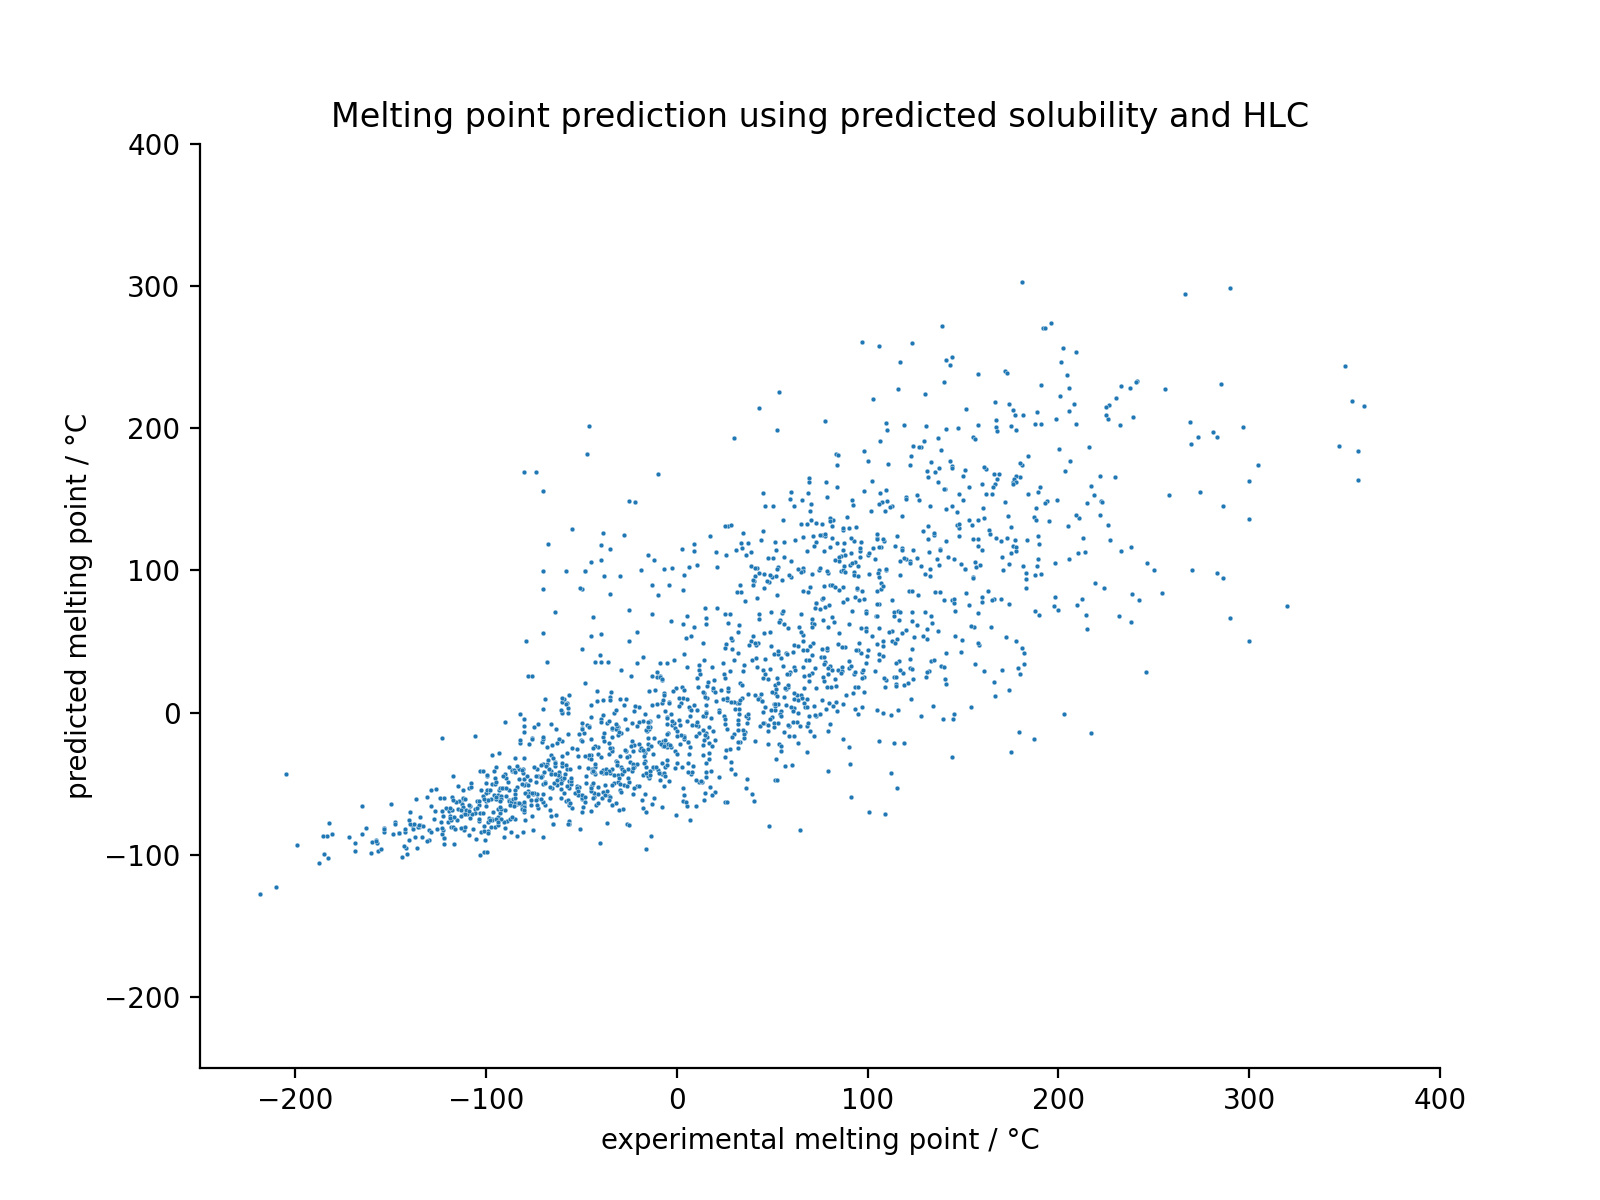

In [45]:
plt.clf()
sns.scatterplot(data=mp_match, x='Melting Point', y='MeltingPointRFRPredicted', s=3).set(title='Melting point prediction using predicted solubility and HLC', xlabel='experimental melting point / °C', ylabel='predicted melting point / °C')

# set axis limits to be the same
plt.xlim(-250, 400)
plt.ylim(-250, 400)

sns.despine()

plt.savefig('mp_prediction_rfr.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
print(mean_squared_error(mp_match['Melting Point'], mp_match['MeltingPointRFRPredicted'], squared=False))

62.46019941970978


In [47]:
r2_score(mp_match['Melting Point'], mp_match['MeltingPointRFRPredicted'])

0.6170267961090692

In [48]:
# exporting dataframe 
mp_match.to_csv('sol_hcp_mp.csv', index=False)